# <center> **TIME SERIES**
## <center> ARIMA, SARIMA, SARIMAX and DEEP LEARNING

# Reference

https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline

#!pip install pmdarima --quiet
import pmdarima as pm

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Data

In [3]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/FernandoSartorGH/data/refs/heads/main/AirPassengers.csv", index_col=False)

#string to date format
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


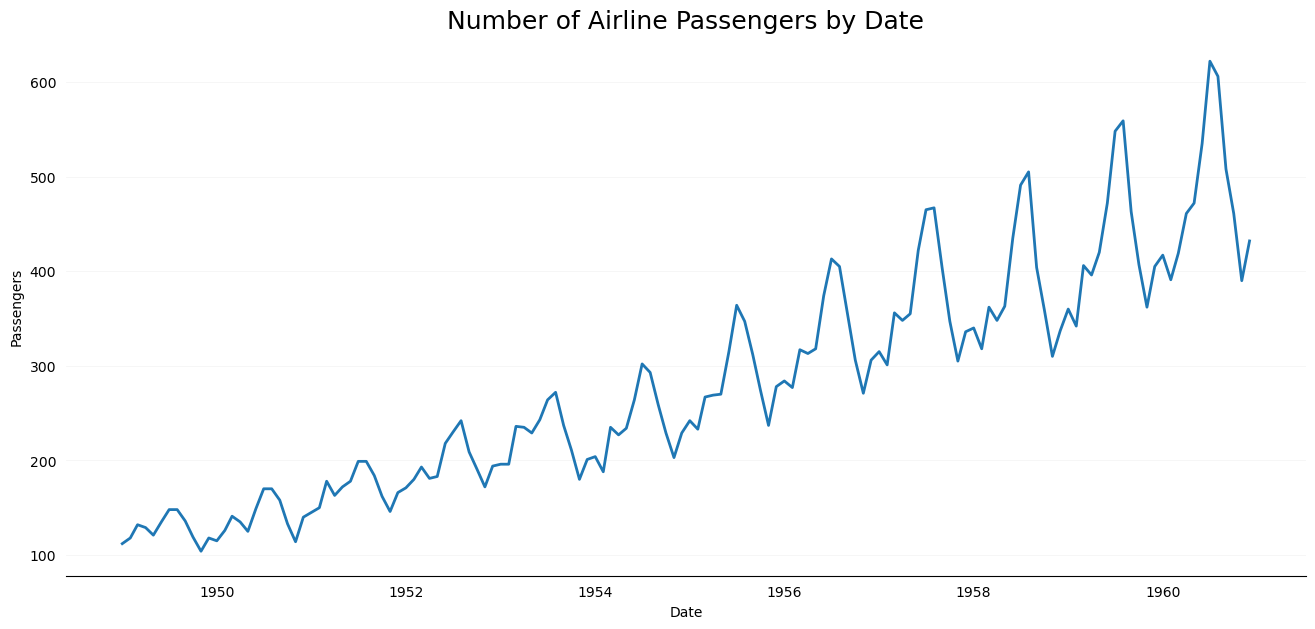

In [4]:
# Plot serie
fig, ax = plt.subplots(figsize = (16,7))

plt.plot(df, linewidth=2)
plt.title("Number of Airline Passengers by Date", fontsize=18)
plt.xlabel('Date')
plt.ylabel('Passengers')

# Remove x, y Ticks
ax.grid(color = 'silver', linestyle = '-', linewidth = 0.5, axis = 'y', alpha = 0.2)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
plt.show()

# Decomposition

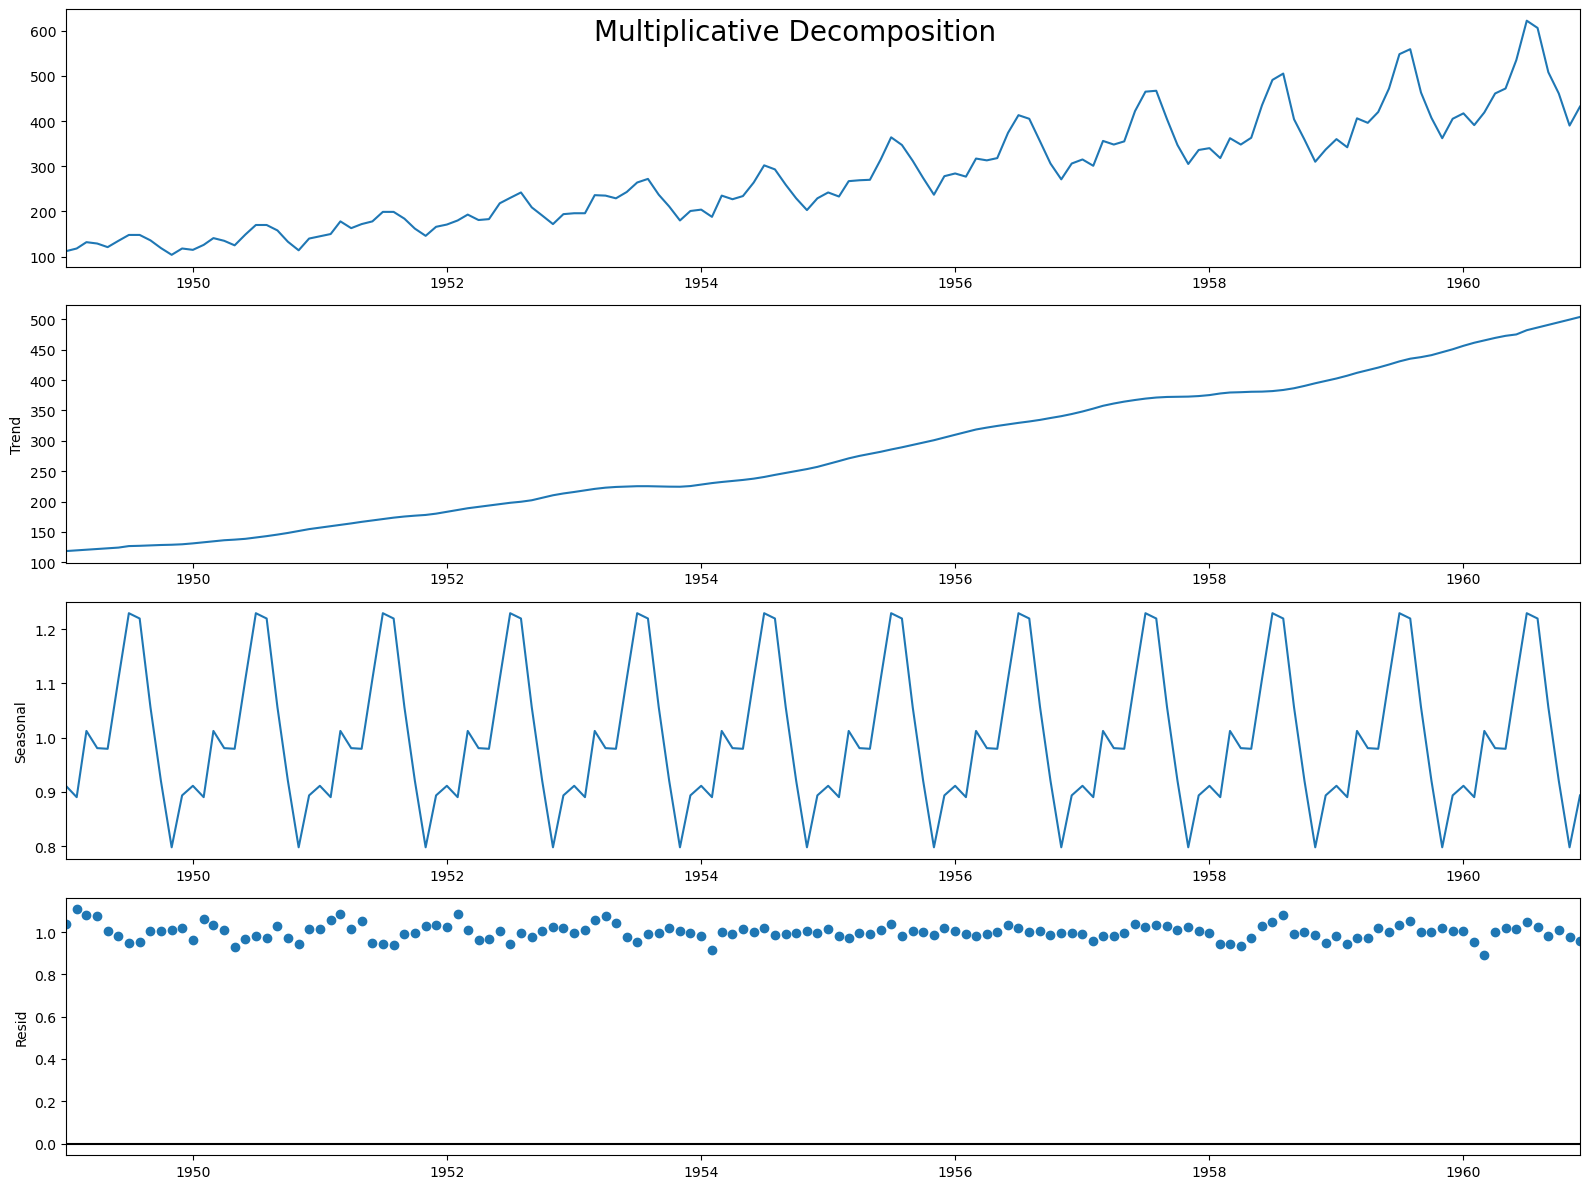

In [5]:
# Multiplicative Decomposition 
multiplicative_decomposition = sm.tsa.seasonal_decompose(df, model = 'multiplicative', extrapolate_trend = 'freq')

# Plot Decomposition
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 20)
plt.show()

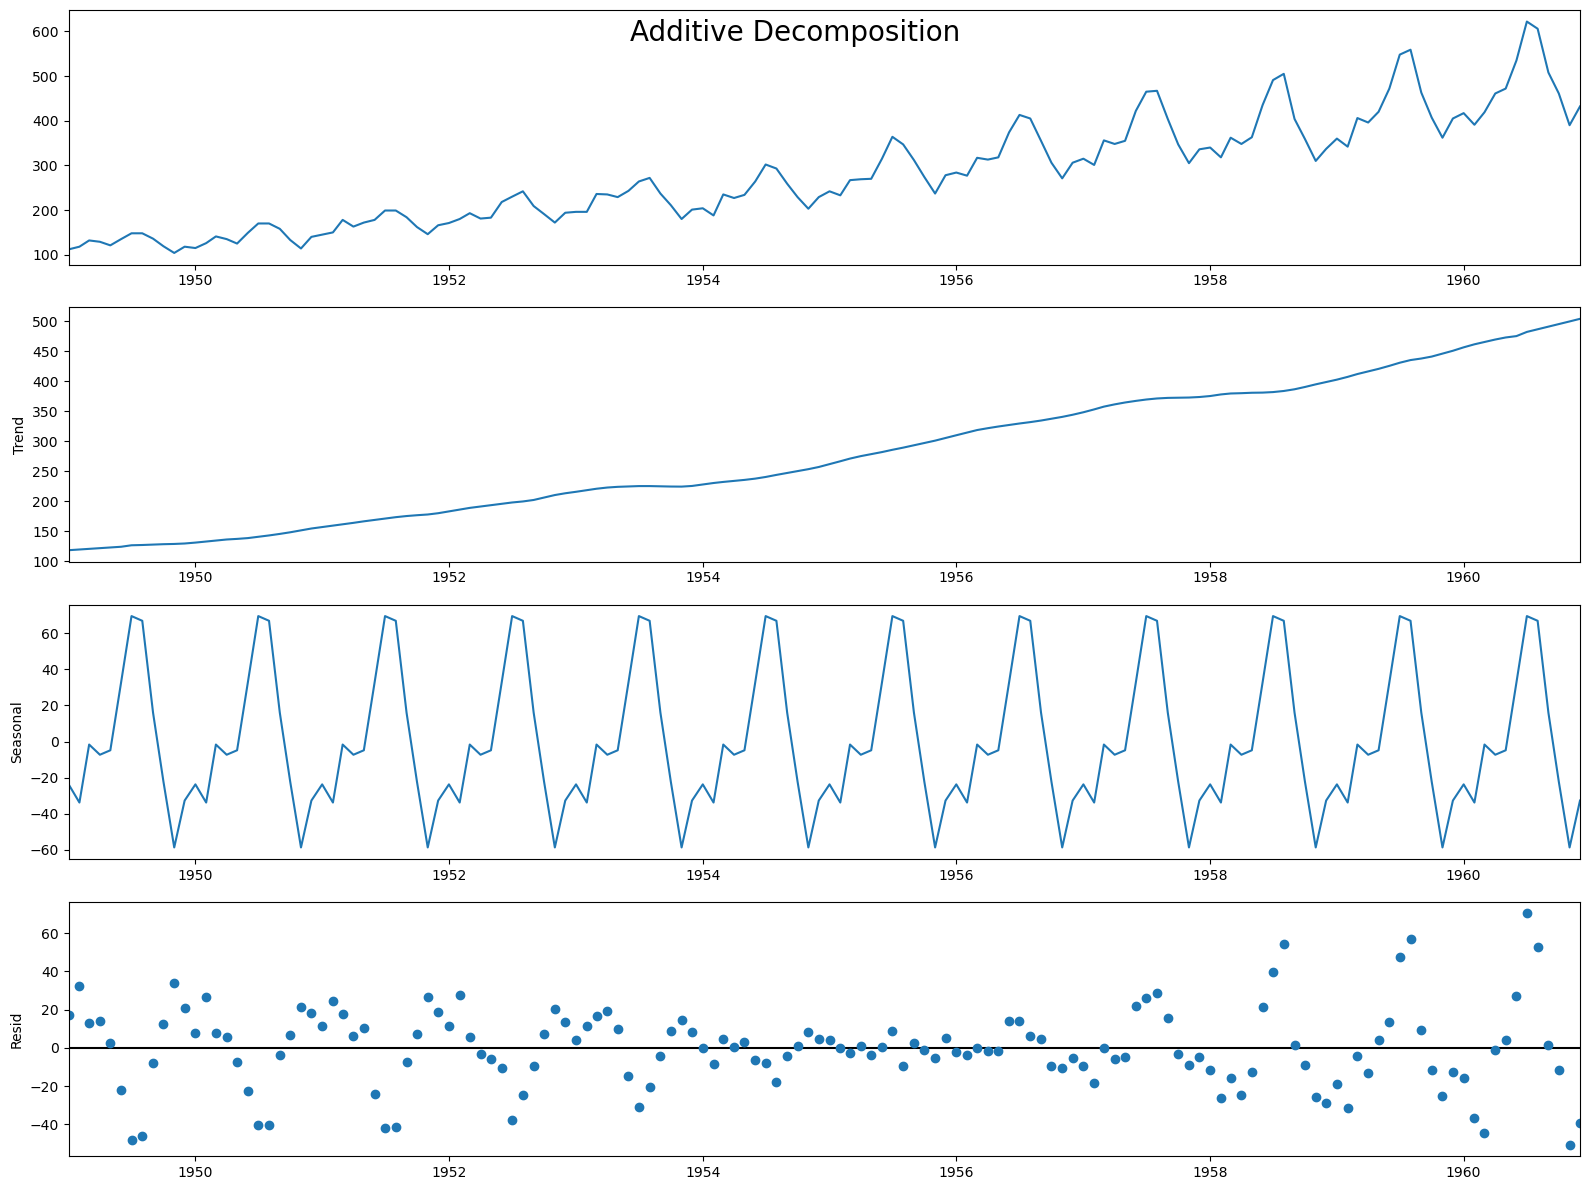

In [6]:
# Additive Decomposition
additive_decomposition = sm.tsa.seasonal_decompose(df, model = 'aditive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 20)
plt.show()

# Training and validation data

In [7]:
df['#Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

In [8]:
df_train = df['#Passengers'][:121]
df_valid = df['#Passengers'][121:]

## **ARIMA**

In [9]:
# Define the forecast function for ARIMA and SARIMA models
def forecast(model, title, periods=24):  # set title as parameter

    # Forecast
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    fig, ax = plt.subplots(figsize = (16,7))
    plt.plot(df_train, color='#1f76b4', linewidth=2)
    plt.plot(df_valid, color='#1f76b4', linewidth=1, linestyle=':')
    plt.plot(fitted_series, color='darkorange', linewidth=2)
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.title(f"{title} - Forecast of Airline Passengers", fontsize=18)
        
    # Remove x, y Ticks
    ax.grid(color = 'silver', linestyle = '-', linewidth = 0.5, axis = 'y', alpha = 0.2)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Remove axes splines
    for s in ['top', 'left', 'right']:
      ax.spines[s].set_visible(False)

    plt.show()

In [10]:
# ARIMA Model
ARIMA_model = pm.auto_arima(df_train, 
                            start_p=1, 
                            start_q=1,
                            test='adf',                                         # adftest to find optimal 'd'
                            max_p=3, max_q=3,                                   # define maximum p and q
                            m=1,                                                # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,                                             # model will determine 'd'
                            seasonal=False,                                     # No Seasonality
                            trace=False,                                        # logs 
                            error_action='warn',                                # shows errors
                            suppress_warnings=True,
                            stepwise=True)

In [11]:
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -568.406
Date:                Sun, 13 Oct 2024   AIC                           1146.811
Time:                        14:58:52   BIC                           1160.790
Sample:                    01-01-1949   HQIC                          1152.489
                         - 01-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.6410     11.889      1.736      0.083      -2.661      43.943
ar.L1          0.4608      0.151      3.060      0.002       0.166       0.756
ar.L2          0.4542      0.156      2.915      0.0

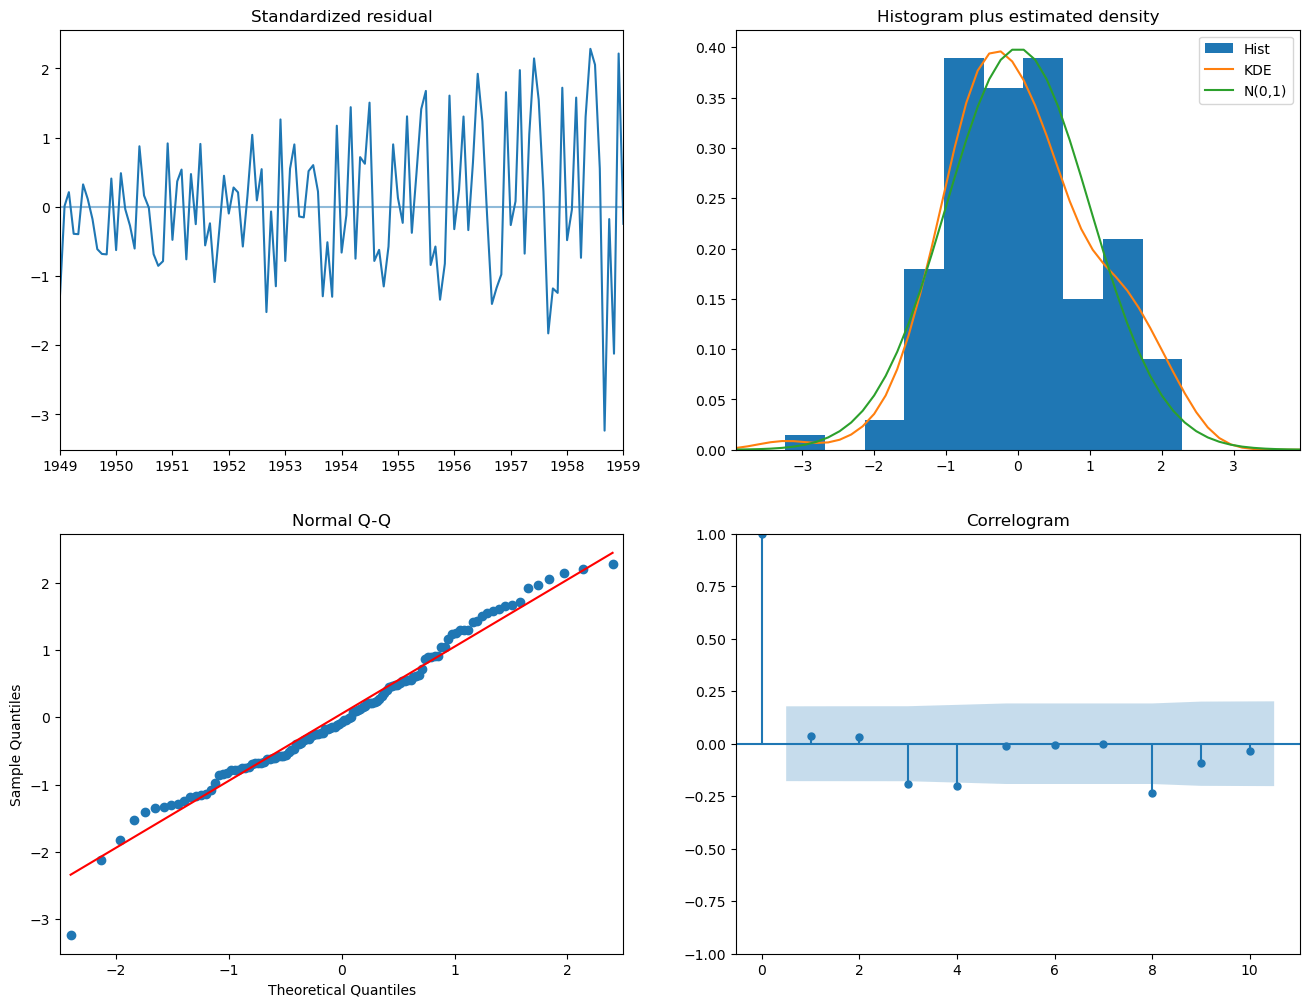

In [12]:
# Show diagnostic
ARIMA_model.plot_diagnostics(figsize=(16,12))
plt.show()

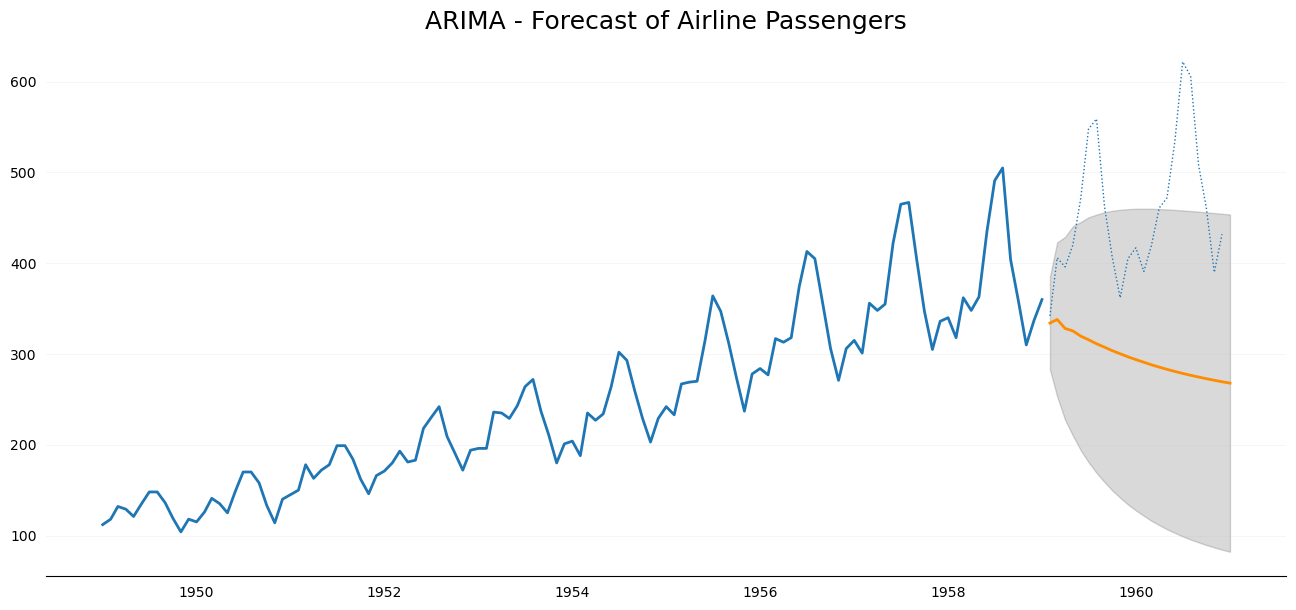

In [13]:
forecast(ARIMA_model, 'ARIMA')

## **SARIMA**

In [14]:
# Define SARIMA model with auto-ARIMA
SARIMA_model = pm.auto_arima(df_train, start_p=1, start_q=1,
                             test='adf',                                        # adftest to find optimal 'd'
                             max_p=3, max_q=3,                                  # define max p and q
                             m=12,                                              # 12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True,                                     # set to seasonal
                             d=None, 
                             D=None,                                               # order of the seasonal differencing
                             trace=False,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

In [15]:
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -404.448
Date:                            Sun, 13 Oct 2024   AIC                            812.895
Time:                                    14:58:55   BIC                            818.259
Sample:                                01-01-1949   HQIC                           815.070
                                     - 01-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2458      0.093     -2.650      0.008      -0.428      -0.064
sigma2       104.7242     12.773   

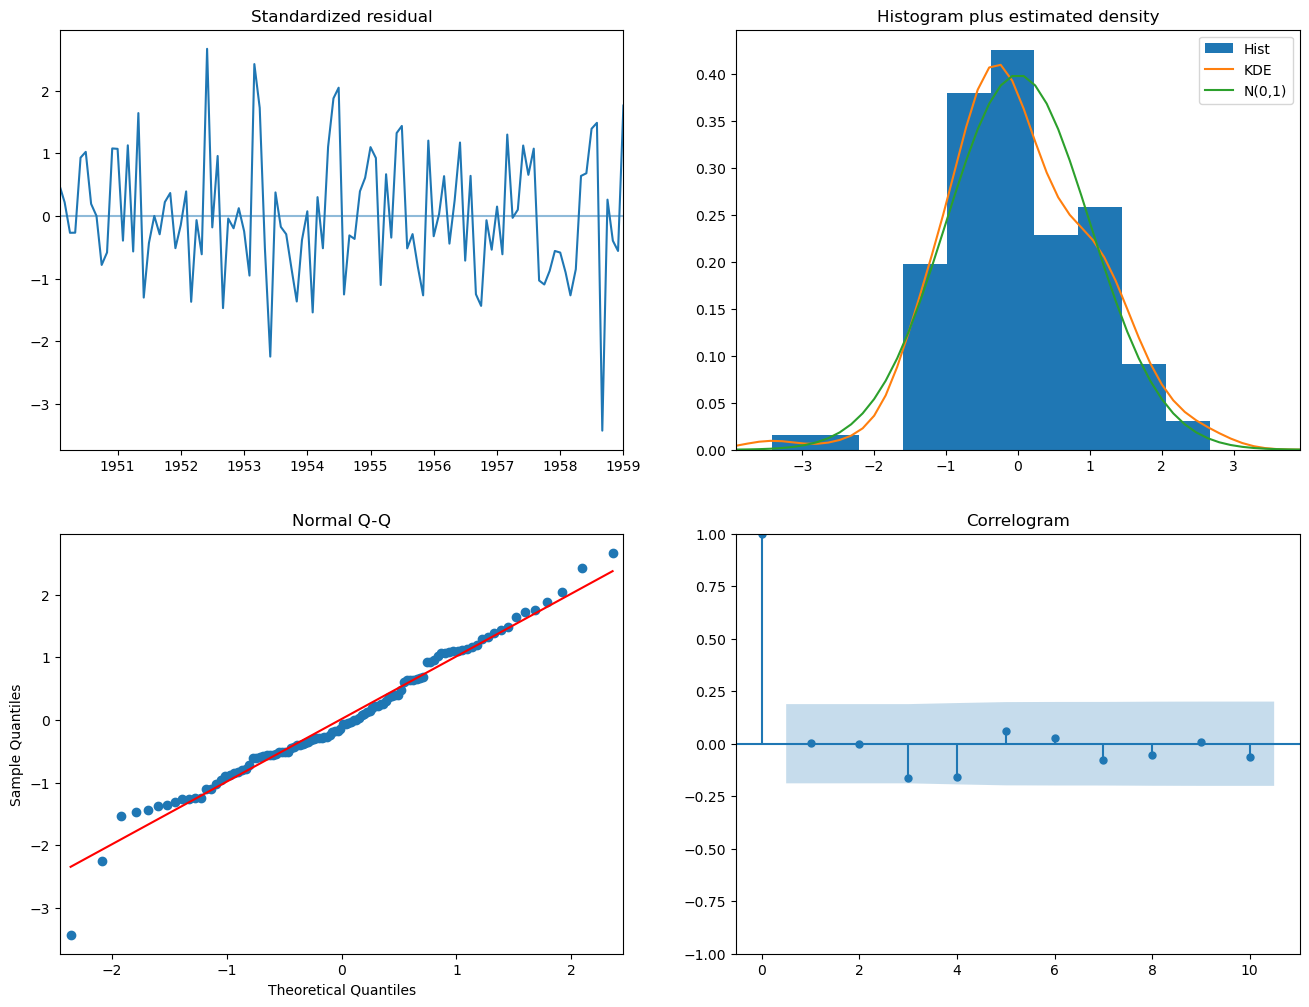

In [16]:
SARIMA_model.plot_diagnostics(figsize=(16,12))
plt.show()

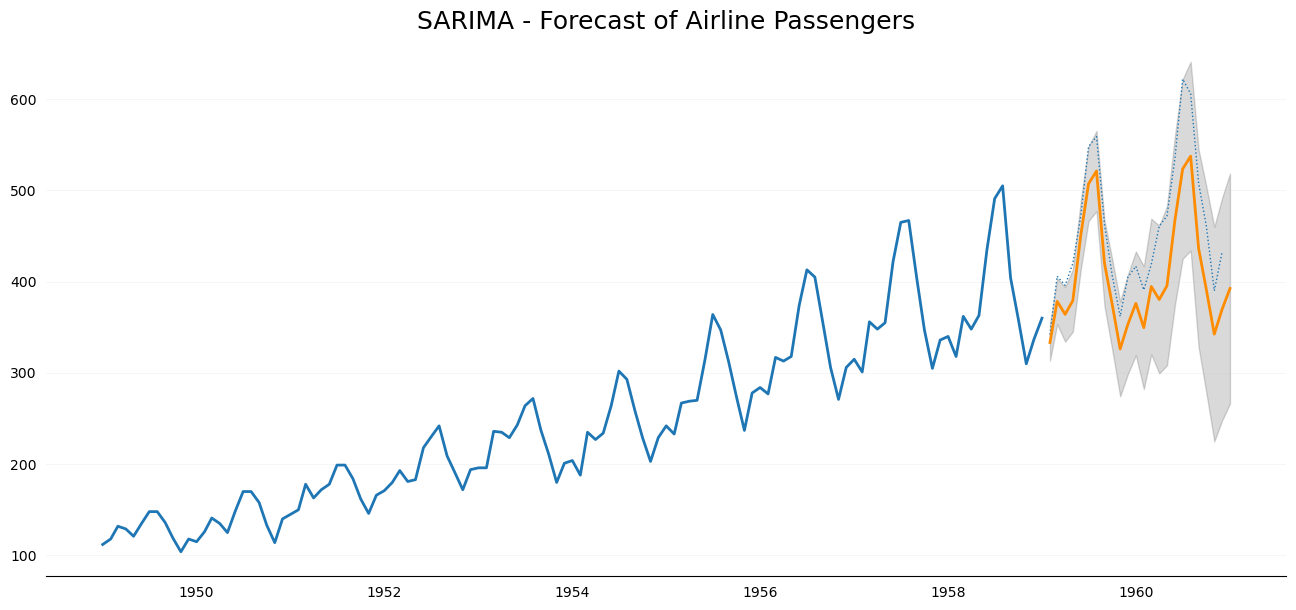

In [17]:
forecast(SARIMA_model, 'SARIMA')

## **SARIMAX**

In [18]:
# Add exogenous variable
df['month_index'] = df.index.month

df_train = df.iloc[:121, :]
df_valid = df.iloc[121:, :]

In [19]:
# Define SARIMAX Model
SARIMAX_model = pm.auto_arima(df_train[['#Passengers']], exogenous=df_train[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',                                       # adftest to find optimal 'd'
                              max_p=3, max_q=3, m=12,                           # define max p and q
                              start_P=0, seasonal=True,
                              d=None, D=None, 
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

In [20]:
print(SARIMAX_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -404.448
Date:                            Sun, 13 Oct 2024   AIC                            812.895
Time:                                    14:58:58   BIC                            818.259
Sample:                                01-01-1949   HQIC                           815.070
                                     - 01-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2458      0.093     -2.650      0.008      -0.428      -0.064
sigma2       104.7242     12.773   

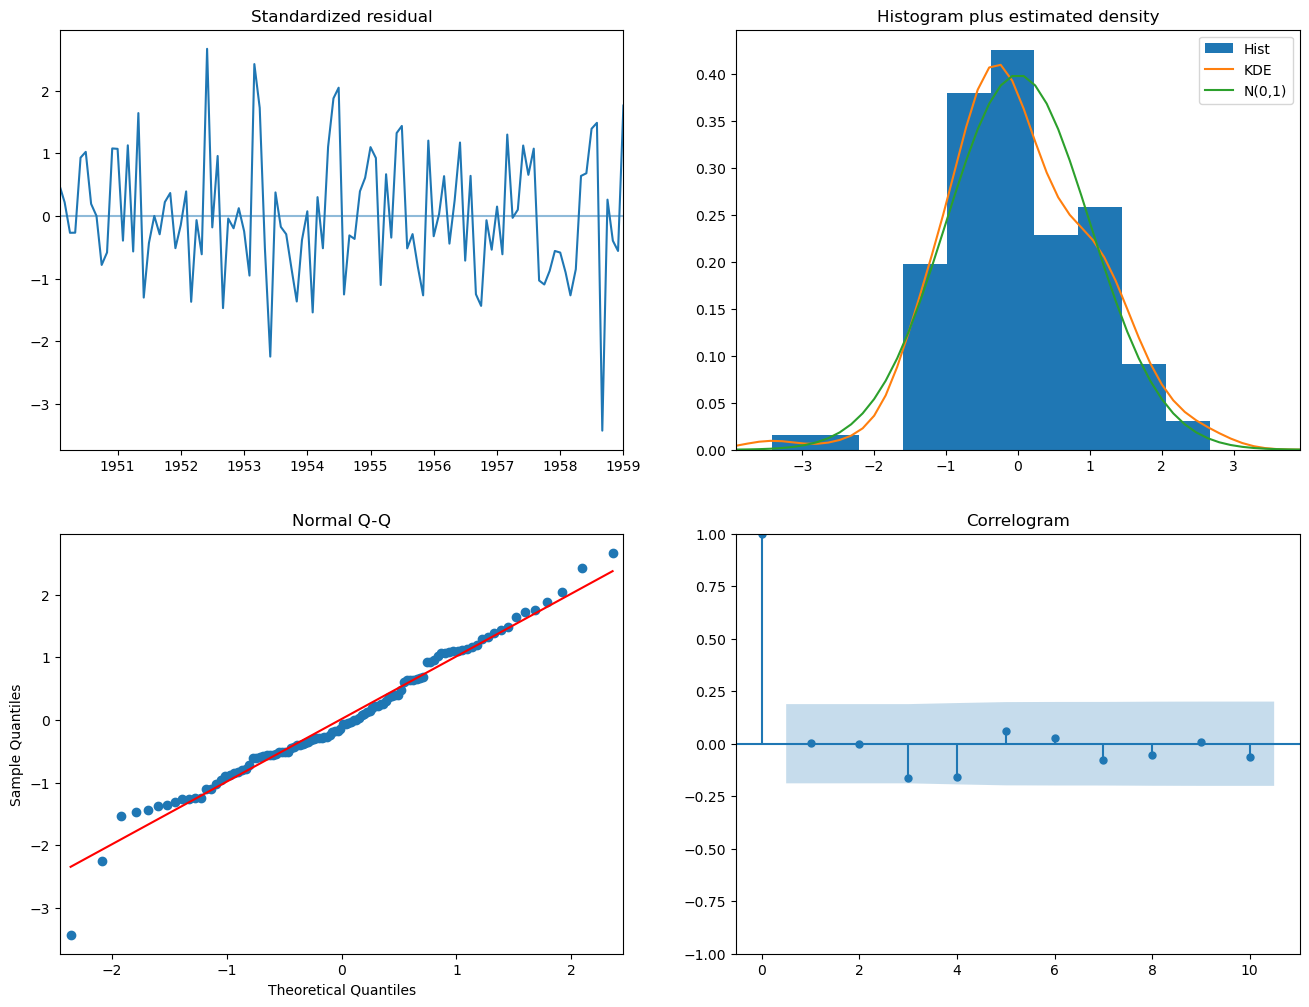

In [21]:
SARIMAX_model.plot_diagnostics(figsize=(16,12))
plt.show()

In [22]:
# Define forecast function for the SARIMAx model
def sarimax_forecast(SARIMAX_model, periods=24):

    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df_train.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df_train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df_train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    fig, ax = plt.subplots(figsize = (16,7))
    plt.plot(df_train["#Passengers"], color='#1f76b4', linewidth=2)
    plt.plot(df_valid["#Passengers"], color='#1f76b4', linewidth=1, linestyle=':')
    plt.plot(fitted_series, color='darkorange', linewidth=2)
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.title("SARIMAX - Forecast of Airline Passengers", fontsize=18)

    # Remove x, y Ticks
    ax.grid(color = 'silver', linestyle = '-', linewidth = 0.5, axis = 'y', alpha = 0.2)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Remove axes splines
    for s in ['top', 'left', 'right']:
      ax.spines[s].set_visible(False)

    plt.show()

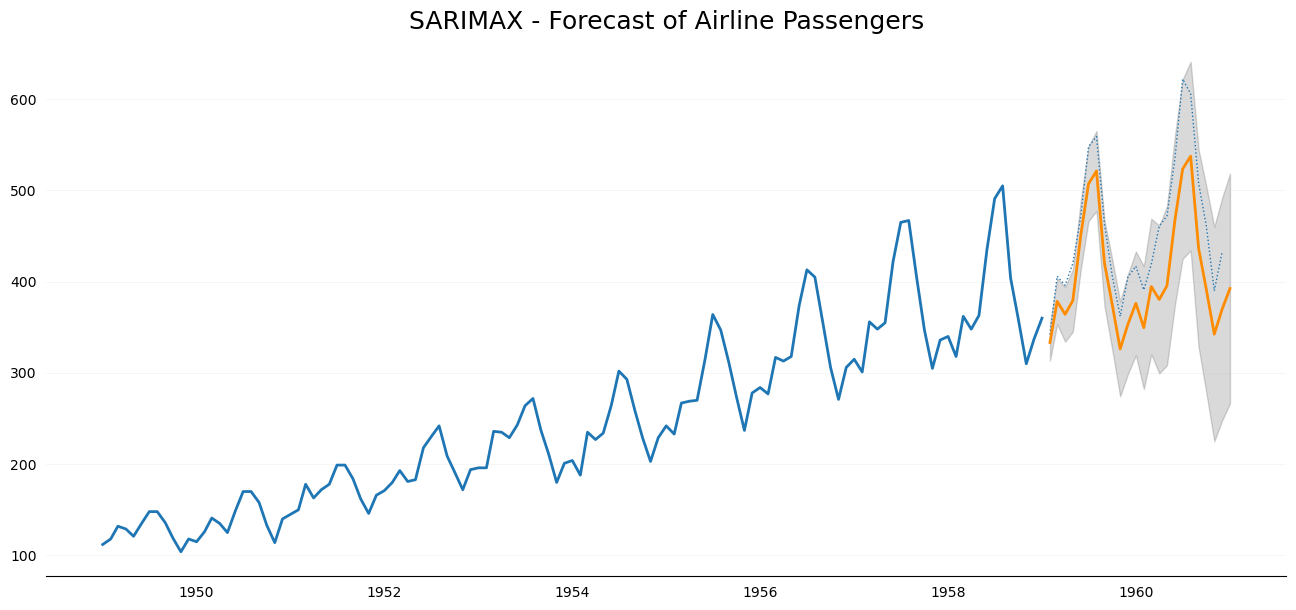

In [23]:
sarimax_forecast(SARIMAX_model, periods=24)

# **RNN**

### Imports

In [24]:
# Import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

### Data

In [25]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/FernandoSartorGH/data/refs/heads/main/AirPassengers.csv", index_col=False)

#string to date format
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [26]:
# Convert the dataframe to a numpy array
df = df.values

# Scale the data to make it applicable for RNN
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df.reshape(-1, 1))

df_scaled

# Split data into predictors and outcomes
# predict the number of passengers using by the past 6 months' number of passengers

X=[]
y=[]
sequence = 6

for i in range(len(df_scaled) - sequence):
    X.append(df_scaled[i:(i + sequence),0]) 
    y.append(df_scaled[i + sequence,0])

X,y = np.array(X),np.array(y)

# Reshape the predictor 
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and test sets 

# Set the size of training and test data
train_size = math.ceil(len(X) * 0.75)
test_size = len(X - train_size)

# Split X and y into training and test sets
X_train = X[:train_size, :]
y_train = y[:train_size]

X_test = X[train_size:len(X),:]
y_test = y[train_size:len(y)]

## **RNN**

In [27]:
# Define predict and Plot function
def RNNForecast(model, X_train, X_test, y_train, y_test, title):

    # Reverse test data to real number
    y_test = y_test.reshape(y_test.shape[0],1)
    y_test = scaler.inverse_transform(y_test)

    y_train = y_train.reshape(y_train.shape[0],1)
    y_train = scaler.inverse_transform(y_train)

    # Predict with RNN model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    # calculate upper and lower bounds of confidence interval
    mse = np.mean((y_pred - y_test)**2)
    n = len(y_test)
    se = np.sqrt(mse / n)
    t = 2.064

    ci_upper = y_pred + t * se
    ci_lower = y_pred - t * se

    # Visualize the results
    x_predicted_axis = np.arange(len(y_train), len(y_train) + len(y_test) , 1)

    fig, ax = plt.subplots(figsize = (16,7))
    plt.plot(y_train, color='#1f76b4',label='Historic data', linewidth=2)

    plt.plot(x_predicted_axis, y_test, color='#1f76b4',label='Test data', linestyle=':')
    plt.plot(x_predicted_axis, y_pred, color='darkorange',label='RNN Predictions', linestyle='-', linewidth=2)
    plt.fill_between(x_predicted_axis, ci_lower[:,0], ci_upper[:,0], color = 'k', alpha=0.1)
    plt.title(f"RNN {title} - Forecast of Airline Passengers", fontsize=18)

    # Remove x, y Ticks
    ax.grid(color = 'silver', linestyle = '-', linewidth = 0.5, axis = 'y', alpha = 0.2)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Remove axes splines
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)

    plt.xlabel('Time')
    plt.ylabel('N of Passengers')
    plt.legend()
    plt.show()

    # Plot the learning history
    #plt.figure(figsize = (14, 7))
    #plt.plot(rnn_history.history['loss'], label='train loss')
    #plt.plot(rnn_history.history['val_loss'], label='val loss')
    #plt.xlabel('epoch')
    #plt.ylabel('loss')
    #plt.legend(loc='best')
    #plt.show()

### Simple RNN

In [42]:
# Define Simple RNN Structure model
rnn = Sequential()

rnn.add(SimpleRNN(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn.add(SimpleRNN(units=32, return_sequences=True))
rnn.add(SimpleRNN(units=32, return_sequences=True))
rnn.add(SimpleRNN(units=32))
rnn.add(Dense(units=1))

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Set Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Train th model
rnn_history = rnn.fit(X_train, y_train,
                      batch_size=64,
                      epochs=500,
                      validation_split=0.2,
                      callbacks=[early_stop],
                      verbose=0)

2/2 [==============================] - 0s 5ms/step


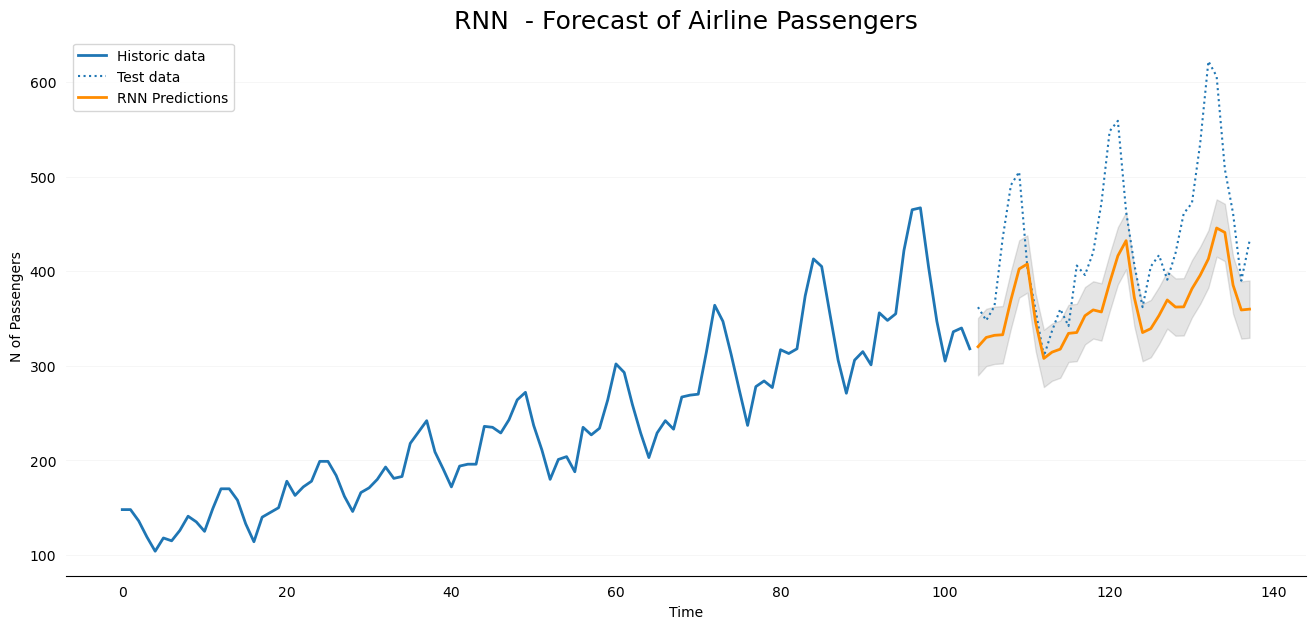

In [43]:
RNNForecast(rnn, X_train, X_test, y_train, y_test, title='')

### LSTM

In [30]:
# Build LSTM model
lstm = Sequential()

lstm.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32))
lstm.add(Dense(units=1))

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
lstm_history = lstm.fit(X_train, y_train,
                        batch_size=32,
                        epochs=3000,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        verbose=0)

2/2 [==============================] - 2s 6ms/step


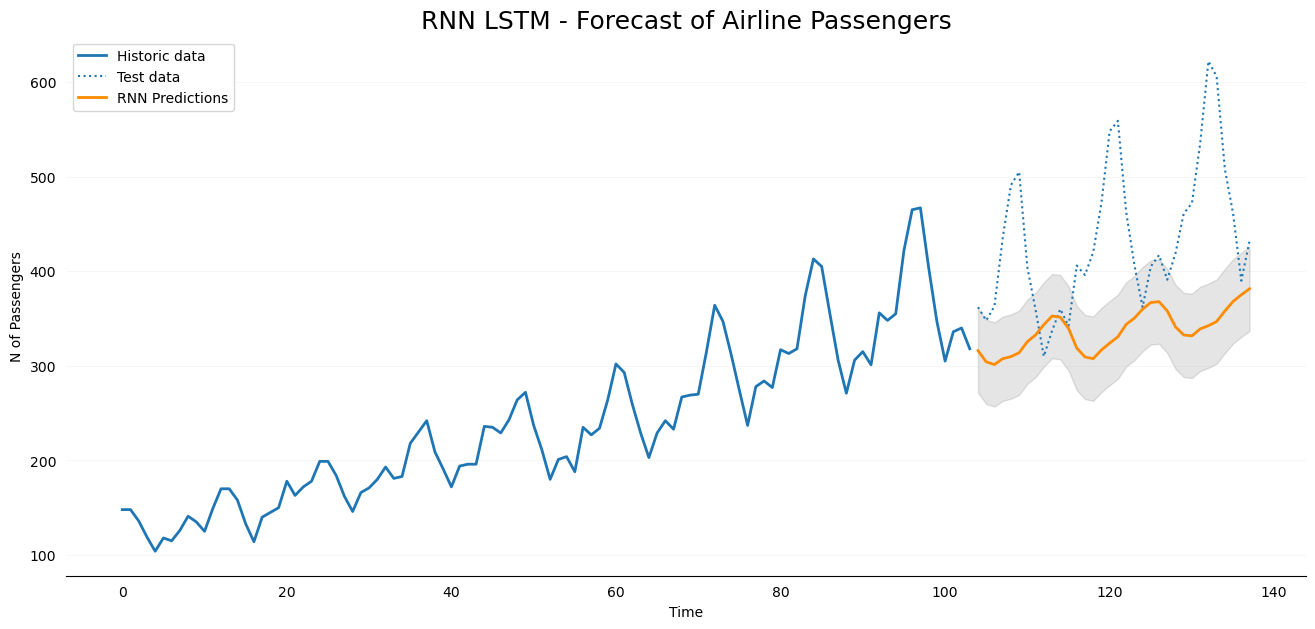

In [31]:
RNNForecast(lstm, X_train, X_test, y_train, y_test, title='LSTM')

### GRU

In [32]:
# Build GRU model
gru = Sequential()

gru.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
gru.add(GRU(units=32, return_sequences=True))
gru.add(GRU(units=32, return_sequences=True))
gru.add(GRU(units=32))
gru.add(Dense(units=1))

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
gru.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
gru_history = gru.fit(X_train, y_train,
                      batch_size=32,
                      epochs=500,
                      validation_split=0.2,
                      callbacks=[early_stop],
                      verbose=0)

2/2 [==============================] - 1s 6ms/step


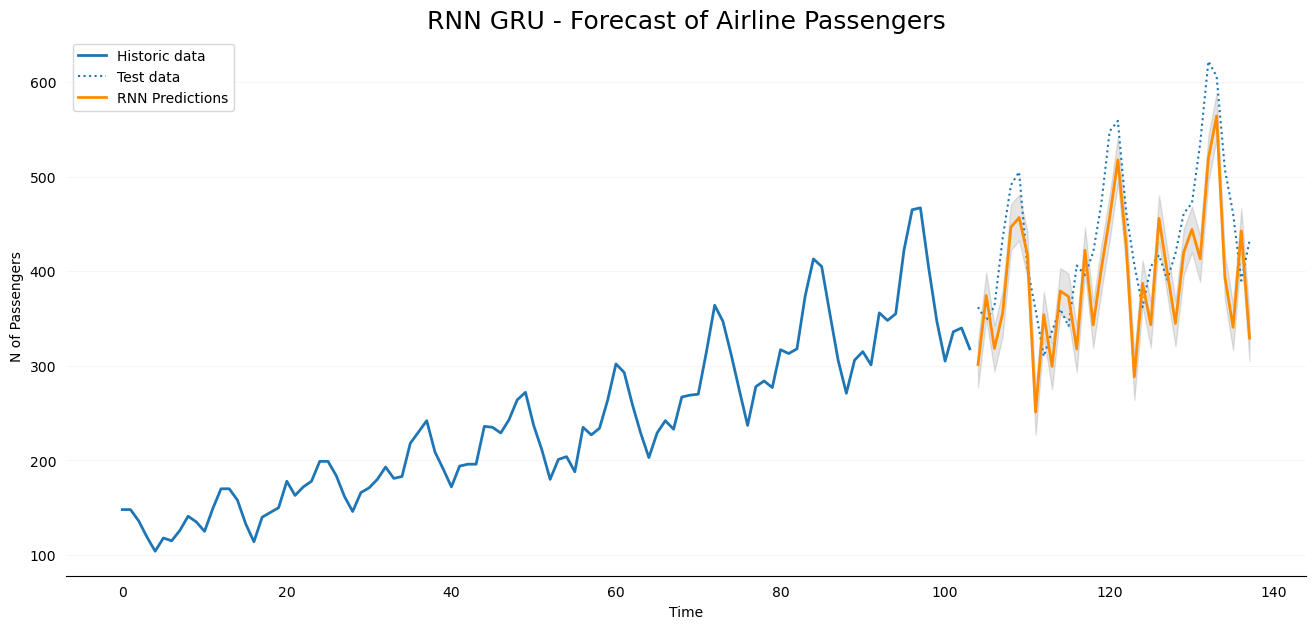

In [33]:
RNNForecast(gru, X_train, X_test, y_train, y_test, title='GRU')

---